In [57]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np

In [58]:
def gen_testdata():
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

In [59]:
#Step 1: Specify the computational domain using the geometry module

geom = dde.geometry.Interval(-1, 1)

#Since  burgers equation is time dependent lets sspecity the time domain as well
timedomain = dde.geometry.TimeDomain(0, 0.99)

#We can combine both the domains using GeometryXTime
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [60]:
#Step 2: Specify the PDE using the grammar of tensorflow
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1) #x[:,1] = t-cordinate
    dy_x = dde.grad.jacobian(y, x, i=0, j=0) #x[:,0] = x-cordinate
    dy_xx = dde.grad.hessian(y, x, i=0, j=0) 
    return dy_t + y*dy_x - 0.01/np.pi * dy_xx # y = u(x, t) and v = 0.01/pi
    

In [61]:
#Step 3: Specify the boundary/initial condition
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary) 
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi*x[:, 0:1]), lambda _, on_initial: on_initial)

In [62]:
#Step 4: Combine the geometry, PDE, and boundary/initial condition to create data.PDE or data.time.PDE
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=2500, num_boundary=100, num_initial=100)

In [63]:
#Step 5: Define the neural network
net = dde.nn.FNN([2] + [20]*3 + [1], "tanh", "Glorot normal")

In [64]:
#Step 6: Combine the data.time.PDE and neural network to create a model 
model = dde.Model(data, net)

In [65]:
#Step 7: Compile the model with hyperparameters like optimized, and learning rate
model.compile("adam", lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.039614 s

'compile' took 0.203170 s



/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


In [66]:
#Step 8: Train the model with the optimizer
model.train(iterations=10000)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.15e-02, 1.27e-02, 4.44e-01]    [2.15e-02, 1.27e-02, 4.44e-01]    []  
1000      [3.72e-02, 5.57e-04, 5.34e-02]    [3.72e-02, 5.57e-04, 5.34e-02]    []  
2000      [2.33e-02, 2.21e-04, 3.03e-02]    [2.33e-02, 2.21e-04, 3.03e-02]    []  
3000      [7.53e-03, 6.06e-05, 5.97e-03]    [7.53e-03, 6.06e-05, 5.97e-03]    []  
4000      [4.75e-03, 3.49e-05, 3.73e-03]    [4.75e-03, 3.49e-05, 3.73e-03]    []  
5000      [3.13e-03, 2.41e-05, 2.88e-03]    [3.13e-03, 2.41e-05, 2.88e-03]    []  
6000      [2.31e-03, 1.78e-05, 2.33e-03]    [2.31e-03, 1.78e-05, 2.33e-03]    []  
7000      [1.86e-03, 1.19e-05, 2.00e-03]    [1.86e-03, 1.19e-05, 2.00e-03]    []  
8000      [1.55e-03, 9.76e-06, 1.77e-03]    [1.55e-03, 9.76e-06, 1.77e-03]    []  
9000      [1.34e-03, 8.32e-06, 1.58e-03]    [1.34e-03, 8.32e-06, 1.58e-03]    []  
10000     [1.21e-03, 8.33e-06, 1.41e-03]    [1.21e-03, 8.33e-

(<deepxde.model.LossHistory at 0x1505119d0>,
 <deepxde.model.TrainState at 0x150418610>)

In [67]:
#Step 9: Retrain using another optimizer if required
model.compile("L-BFGS-B")

Compiling model...
'compile' took 0.148439 s



In [68]:
X = geomtime.random_points(100000)
err = 1

In [69]:
while err > 0.005:
    f = model.predict(X, operator=pde)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))

    x_id = np.argmax(err_eq)
    print("Adding new points: ,", X[x_id], "\n")
    data.add_anchors(X[x_id])
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile("adam", lr=1e-3)
    model.train(iterations=10000, disregard_previous_best=True, callbacks=[early_stopping])
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

Mean residual: 2.367e-02
Adding new points: , [0.00810516 0.9843213 ] 

Compiling model...
'compile' took 0.102453 s

Training model...

Step      Train loss                        Test loss                         Test metric
10000     [2.03e-03, 8.33e-06, 1.41e-03]    [1.21e-03, 8.33e-06, 1.41e-03]    []  


2024-04-04 15:54:56.574546: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_19/bias/Adam_3/Assign' id:10741 op device:{requested: '', assigned: ''} def:{{{node dense_19/bias/Adam_3/Assign}} = Assign[T=DT_FLOAT, _class=["loc:@dense_19/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](dense_19/bias/Adam_3, dense_19/bias/Adam_3/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


11000     [1.36e-03, 7.91e-06, 1.40e-03]    [1.31e-03, 7.91e-06, 1.40e-03]    []  
12000     [2.58e-03, 4.76e-06, 1.36e-03]    [2.45e-03, 4.76e-06, 1.36e-03]    []  
13000     [1.15e-03, 1.12e-05, 1.22e-03]    [1.14e-03, 1.12e-05, 1.22e-03]    []  
14000     [1.10e-03, 8.60e-06, 1.10e-03]    [1.09e-03, 8.60e-06, 1.10e-03]    []  
15000     [1.08e-03, 7.67e-06, 1.01e-03]    [1.07e-03, 7.67e-06, 1.01e-03]    []  
16000     [9.07e-04, 6.16e-06, 9.03e-04]    [8.89e-04, 6.16e-06, 9.03e-04]    []  
17000     [8.60e-04, 5.80e-06, 8.23e-04]    [8.45e-04, 5.80e-06, 8.23e-04]    []  
18000     [8.17e-04, 5.36e-06, 7.56e-04]    [8.03e-04, 5.36e-06, 7.56e-04]    []  
19000     [2.78e-03, 3.51e-06, 7.19e-04]    [2.64e-03, 3.51e-06, 7.19e-04]    []  
20000     [7.42e-04, 6.76e-06, 6.43e-04]    [7.30e-04, 6.76e-06, 6.43e-04]    []  

Best model at step 20000:
  train loss: 1.39e-03
  test loss: 1.38e-03
  test metric: []

'train' took 40.212800 s

Compiling model...
'compile' took 0.115747 s

Trainin

2024-04-04 15:56:31.910997: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_19/bias/Adam_5/Assign' id:12529 op device:{requested: '', assigned: ''} def:{{{node dense_19/bias/Adam_5/Assign}} = Assign[T=DT_FLOAT, _class=["loc:@dense_19/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](dense_19/bias/Adam_5, dense_19/bias/Adam_5/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


27000     [3.97e-04, 1.64e-07, 2.95e-05]    [3.32e-04, 1.64e-07, 2.95e-05]    []  
28000     [1.18e-04, 3.41e-08, 1.32e-05]    [1.12e-04, 3.41e-08, 1.32e-05]    []  
29000     [7.20e-05, 4.44e-08, 7.94e-06]    [7.00e-05, 4.44e-08, 7.94e-06]    []  
30000     [5.89e-05, 3.92e-08, 6.35e-06]    [5.69e-05, 3.92e-08, 6.35e-06]    []  
Epoch 30000: early stopping

Best model at step 30000:
  train loss: 6.53e-05
  test loss: 6.33e-05
  test metric: []

'train' took 12.758074 s

Compiling model...
'compile' took 0.103456 s

Training model...

Step      Train loss                        Test loss                         Test metric
30000     [5.89e-05, 3.92e-08, 6.35e-06]    [5.69e-05, 3.92e-08, 6.35e-06]    []  
31000     [1.24e-05, 2.81e-08, 1.16e-06]    [1.24e-05, 2.81e-08, 1.16e-06]        
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000011
  Number of iterations: 1464
  Number of functions evaluatio

Saving loss history to /Users/bipuladhikari/Documents/neuralNetwork/myDeepXDE/BurgersEquation/loss.dat ...
Saving training data to /Users/bipuladhikari/Documents/neuralNetwork/myDeepXDE/BurgersEquation/train.dat ...
Saving test data to /Users/bipuladhikari/Documents/neuralNetwork/myDeepXDE/BurgersEquation/test.dat ...


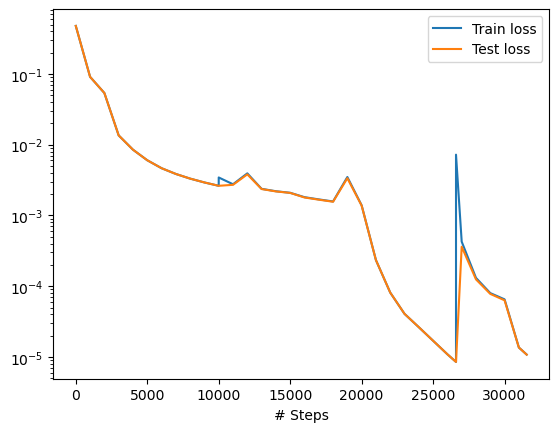

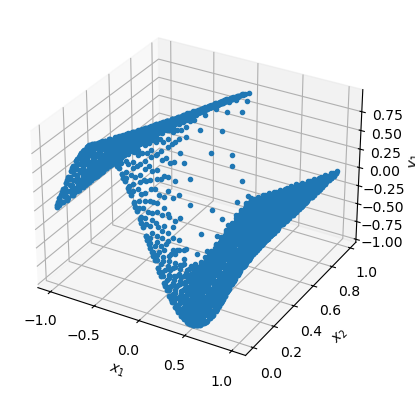

In [70]:
#Displaying the graph depicting train loss and test loss over time, along with a graph displaying the predicted solution to the PDE
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [71]:
X, y_true = gen_testdata()
y_pred = model.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

L2 relative error: 0.002635358319520584


In [32]:
#Step 10: predict
losshistory, train_state = model.train()

Training model...

Step      Train loss                        Test loss                         Test metric
10000     [1.02e-03, 2.93e-06, 8.61e-04]    [1.02e-03, 2.93e-06, 8.61e-04]    []  
11000     [1.65e-04, 1.19e-06, 7.97e-05]    [1.65e-04, 1.19e-06, 7.97e-05]        
12000     [7.01e-05, 3.59e-07, 2.40e-05]    [7.01e-05, 3.59e-07, 2.40e-05]        
13000     [3.69e-05, 1.21e-07, 8.96e-06]    [3.69e-05, 1.21e-07, 8.96e-06]        
14000     [1.92e-05, 6.77e-08, 4.67e-06]    [1.92e-05, 6.77e-08, 4.67e-06]        
15000     [1.20e-05, 5.74e-08, 2.25e-06]    [1.20e-05, 5.74e-08, 2.25e-06]        
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000011
  Number of iterations: 5267
  Number of functions evaluations: 5566
15558     [9.71e-06, 5.63e-08, 1.58e-06]    [9.71e-06, 5.63e-08, 1.58e-06]    []  

Best model at step 15558:
  train loss: 1.13e-05
  test loss: 1.13e-05
  test metric: []

'train' 